## Volume of News stories

**PROBLEM**: How do we detect which topics/industries are getting lots of News coverage? It is important for various players in the financial market to understand the changes that affect the market and consequently their portfolio. 

**SOLUTION**: To solve the above, we need several components in place. 
* A comprehensive classification scheme that would cover all the topics and industries - Refintiv classification schema has thousands of topics & industries - categorized for ease of discovery  
* A good set of News sources that would cover all the pertinent topics/industries across the globe - think Reuters, News wires  
* A feed of all the sources in one data format/schema so that one can easily ingest and query the data 

To bring this alive, we are going to 
* Pull Historical News stories from Refinitiv News sources on Diseases related Topic codes
* Chart the Volume for stories for each Topic Code
* Compare Volumes for related Topic codes


### Health Related Codes

| RCS Code | News200 Code | Topic                 | Description|
|----------|------------|-----------------------|-----------------------------------------------------------------------------------------|
| M:1N7    | COMDIS     | Communicable Diseases | General news on research into, causes, prevention and treatment of communicable diseases|
| M:1N6    | DISEAS     | Diseases              | General news on research into, causes, prevention and treatment of diseases|
| M:JJ     | INFDIS     | Infectious Diseases   | Research into, causes and treatment of all infectious diseases, including food poisoning, hepatitis, influenza, malaria and sexually transmitted diseases (STDs)|
| M:1LP    | PUBHEA     | Public Health         | Issues and policies affecting Public Health systems, including disease outbreaks, disease prevention programs, disease control programs, health trends, municipal resources, public education, public policies |
| M:1LD    | HCPOL      | Healthcare Policy     | Health insurance, law, government policy about healthcare |
|          |            |                       |    |
| **M:P**  | **HEA**    | **Health/Medicine**   | **Health; disease; medical research; preventative medicine; hospitals; government policy** |

<br>

The **RCS** topic code is the newer strategic system and the **News2000** code is the legacy system.  
For all new developments we recommend customers use RCS code (Refinitiv Classification Schema)

News2000 codes & RSC codes are a one-to-one mappings ~99% of the time.


### Realtime Streaming and Archive Files

Depending on your use case, you can access our News Stories and Sentiment scoring data as 
* Live Streaming Feed
* Archived Bulk File versions

I will be using Bulk Files transferred into a database

### The Code

In [16]:
import pymysql
import configparser as cp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import numpy as np
%matplotlib inline


config = cp.ConfigParser()
config.read("exconfig.cfg")
DATABASE="newsanalyticsdb"
datafile="Health.xlsx"
myConn = ""
writeToXl = False    # Used to dump data to excel file after sourcing data from DB
loadFromXl = True    # Load data from Excel file rather than DB
plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams["figure.facecolor"] = '0.25'
plt.rcParams["axes.labelsize"] = '20'
plt.rcParams["font.size"] = '20.0'
plt.rcParams["axes.labelcolor"] = 'y'
plt.rcParams["text.color"] = 'c'
plt.rcParams["legend.facecolor"]='0.25'

if not loadFromXl:
    try:
        myConn = pymysql.connect(
          host="localhost",
          user=config['mysql']['user'],
          passwd=config['mysql']['password'],
          database=DATABASE
        )
    except pymysql.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)      
    else:
        print("Connected to "+ DATABASE)   
else:
    print("Loading data from "+ datafile)   
        
if writeToXl:
    writer = pd.ExcelWriter(datafile, engine='xlsxwriter')
    

Loading data from Health.xlsx


Note that I have added the option to load the data form an Excel file  rather than the MySql database. I did this primarily to speed up my testing - as the MySql queries can be somewhat time consuming.

This also means that if  you don't have a Refintiv News Analytics licence (and therefore  unable to populate a database), you can still run this notebook by setting the *loadFromXl* parameter to True and ensuring the *Health.xlsx* is in the working folder.

### Helper Functions
Main code to fetch data from DB based on Topic Code (or read from file)

In [2]:
def fetch_topic(code):
    if loadFromXl:
        df = pd.read_excel(datafile, sheet_name=code)
        df['Date'] = df['Date'].dt.date
    else:
        query = ("SELECT feedDate as Date, COUNT(*) as " + code + 
                    " FROM news "
                    "WHERE subjects "
                    "LIKE '%N2:" + code + "%' " 
                    "AND WEEKDAY(feedDate)<5 "
                    "GROUP BY feedDate "
                    "ORDER BY feedDate"    )
        SQL_Query = pd.read_sql_query(query, myConn)
        df = pd.DataFrame(SQL_Query)
        if writeToXl:
            df.to_excel(writer, sheet_name=code,index=False)
    return df

#### Chart Plot code

In [3]:
def plot_data(df,code):
    ax = df.plot(x = 'Date', y = code, kind='line', 
                title = code +' Stories by Date', color = 'orange',
                xlabel = 'Date', ylabel = 'Volume')
    ax.set_facecolor('0.25')
    ax.tick_params(axis='both', colors='w', labelsize=20)

#### Plot multiple topics

In [4]:
def plot_compare(df1,df2):
    df = pd.merge(df1, df2, on='Date', how='outer', sort=True)
    ax = df.plot(x='Date', kind='line', title = 'Compare Volumes by Date',
                xlabel = 'Date',ylabel = 'Volume',fontsize=5,
                color = ['orange','red', 'blue', 'green'])
    ax.set_facecolor('0.25')
    ax.tick_params(axis='both', colors='w', labelsize=20)
    return df

#### Fetch Data and Plot Chart

In [5]:
def plot_topic(code):
    df = fetch_topic(code)
    plot_data(df,code)
    return df

##### Plot Volume of Infectious Disease and other related Topic stories
   
   
Infectious Diseases - **INFDIS**

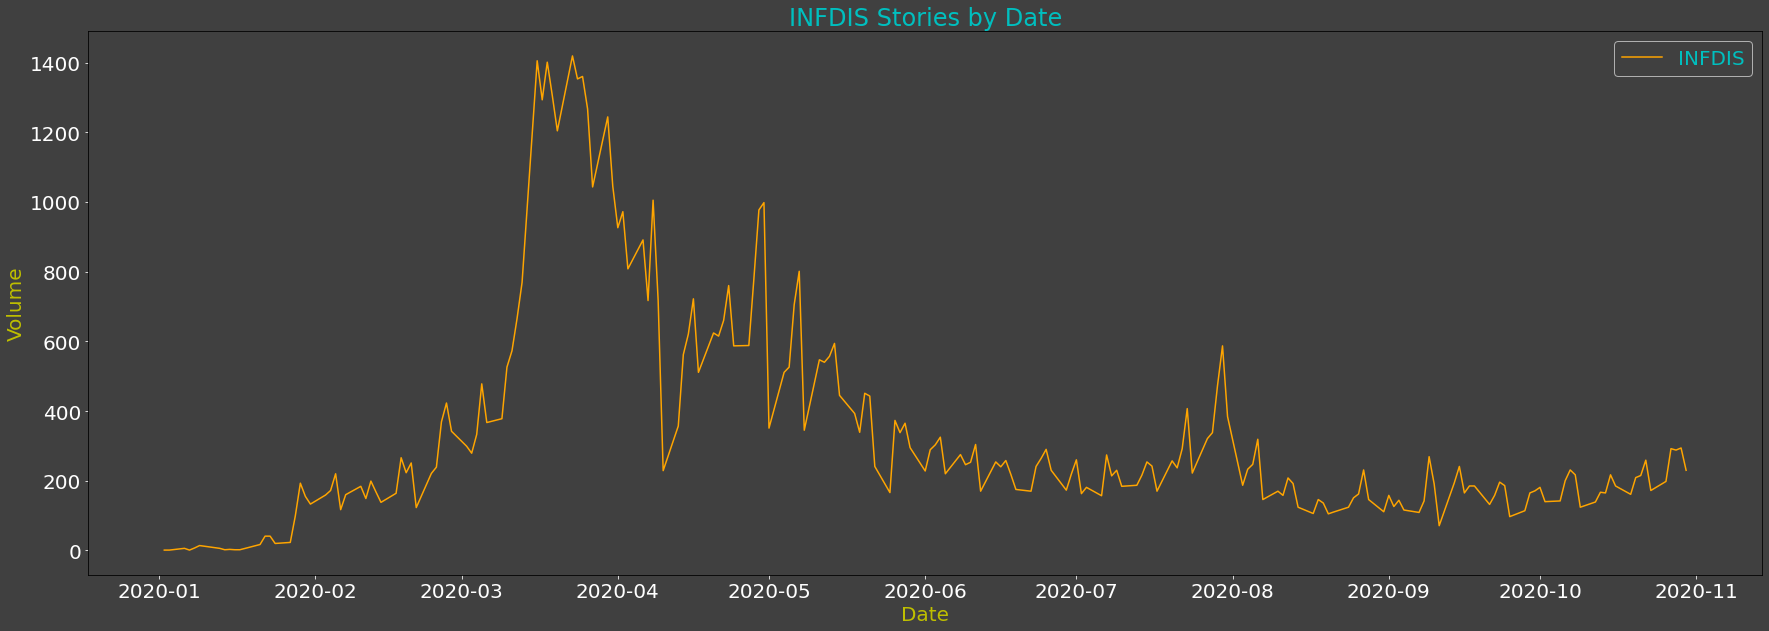

In [6]:
df_infdis = plot_topic('INFDIS')

You will notice the high volumes in March - April and another spike in August with the volume of stories increasing by a factor of approx. 3 during March. 

However, the more interesting activity is from late January to March:
* Note how the normal daily volume at the start of the year is around the 10-20 mark
* From late Jan this starts multiplying so much that early February this has increased by a factor of 10+ to 200+ stories a day
* By March we are getting between 400-500 stories a day - so increased by a factor of 25+ compared to the start of the year!     

A savvy investor could have started to note the huge increases in late January and potentially started taking action

<br>  
<br>
Communicable Diseases - **COMDIS** - infectious disease that is contagious

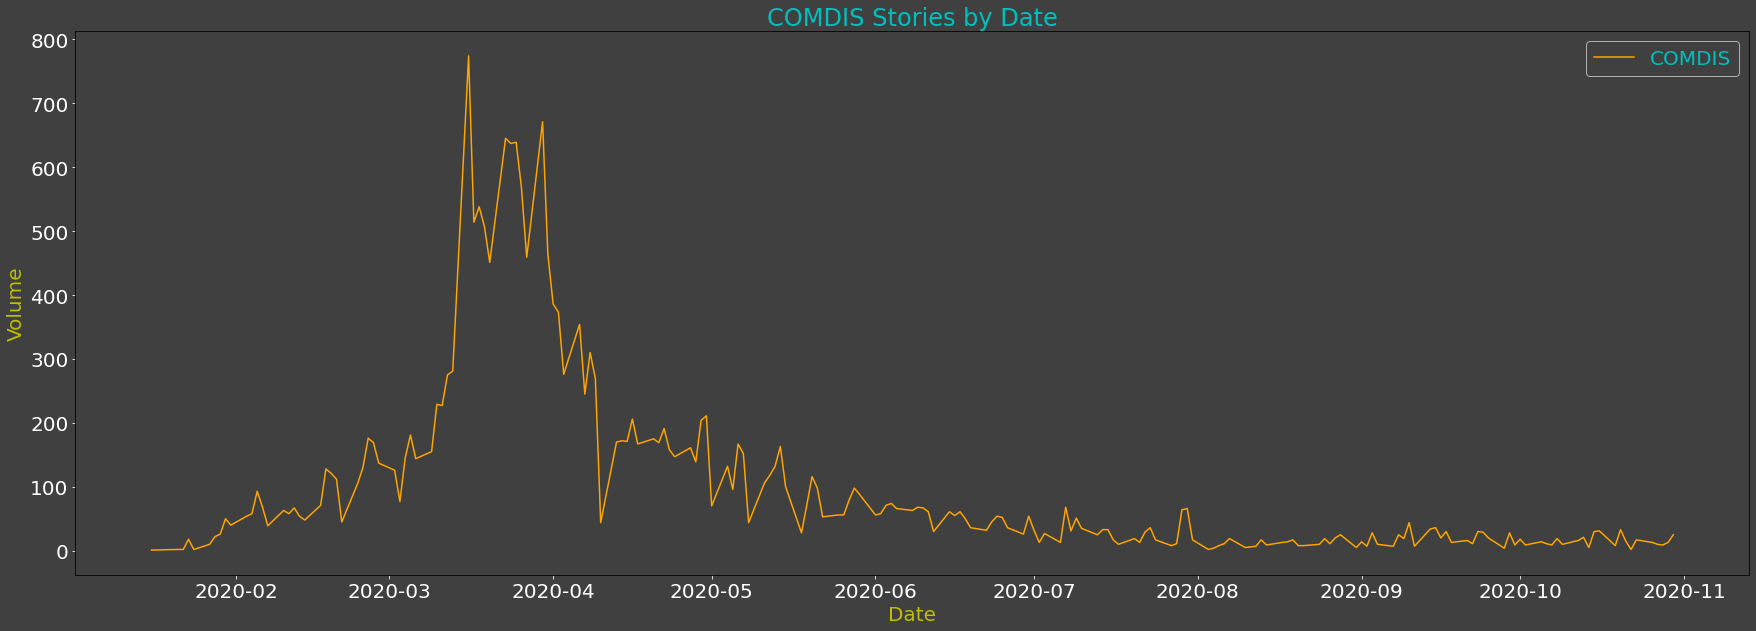

In [7]:
df_comdis = plot_topic('COMDIS')

Notice how the overall pattern is similar **INFDIS** but there is divergence in places and the volumes are lower too
<br>

General Disease related stories - **DISEAS**

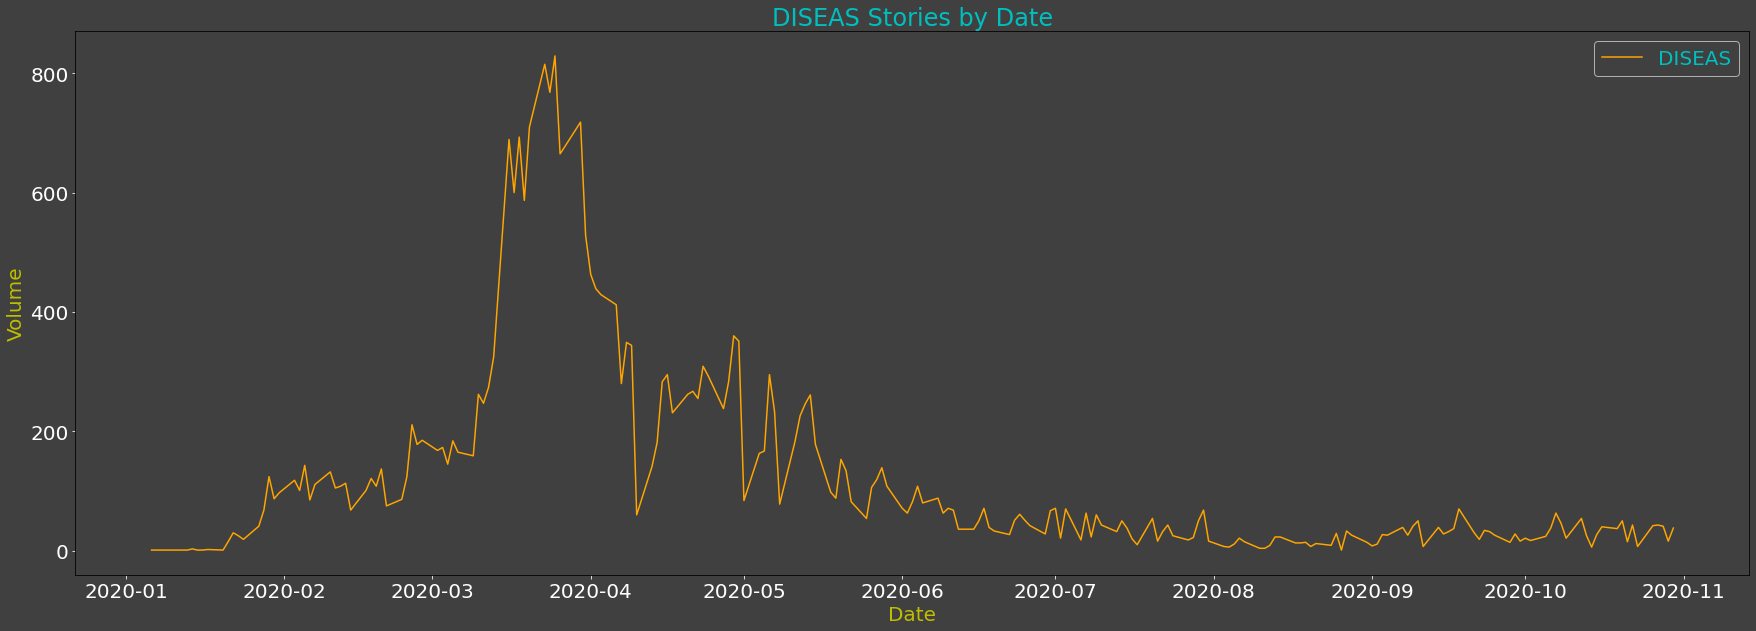

In [8]:
df_diseas = plot_topic('DISEAS')

Once again, notice how the overall pattern is similar **INFDIS** but there are divergences in places and the volumes are lower too.

Therefore, it is important to select the most appropriate topic code(s) as per your requirement. If you are unsure, you should consult a News Data specialist at Refinitiv.  

<br>  

Health Policy - **HCPOL** - Health insurance, law, government policy about healthcare

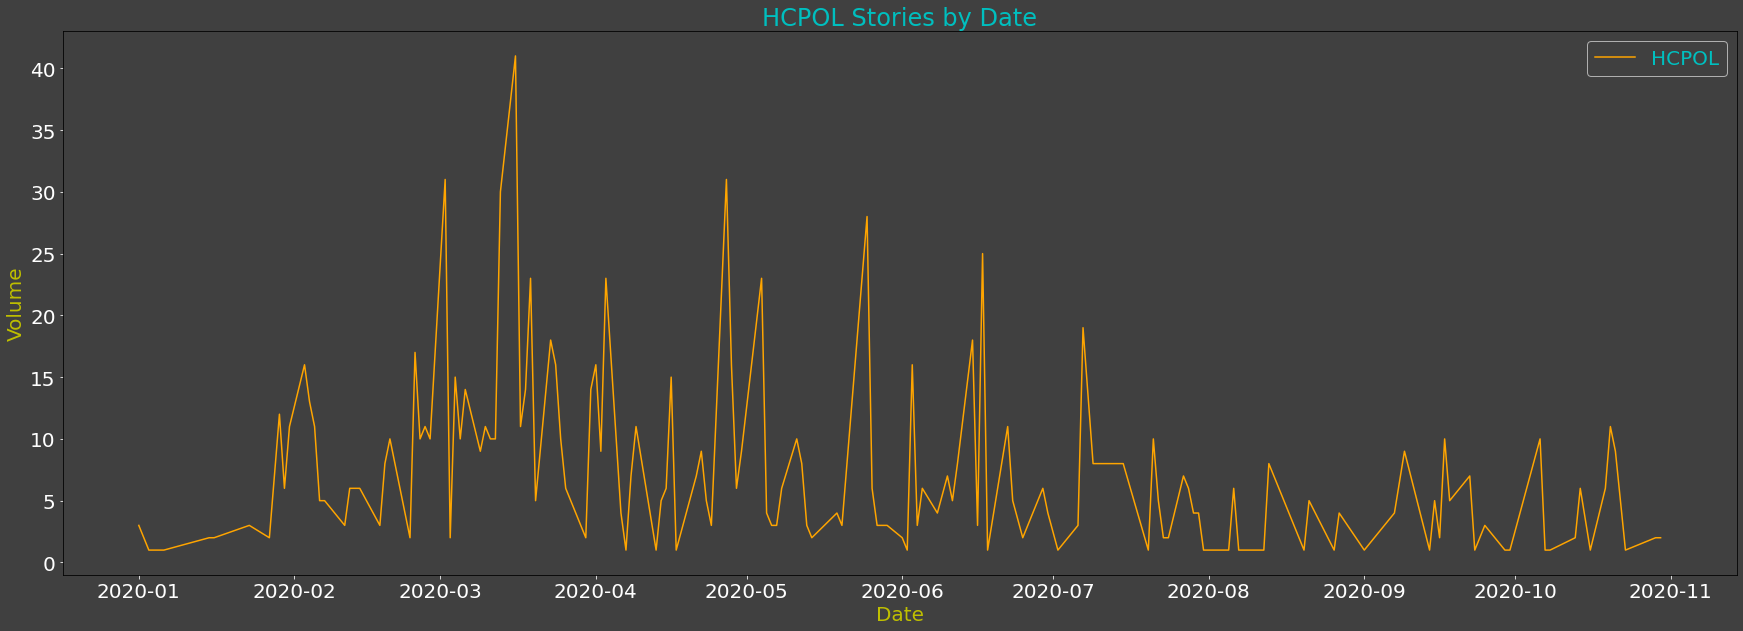

In [9]:
df_hcpol = plot_topic('HCPOL')

Whilst we see many more spikes, the overall pattern is somewhat different. This is most likely because Government policy announcements were made more often throughout the year.

<br>

Public Health - **PUBHEA** - Issues and policies affecting Public Health systems

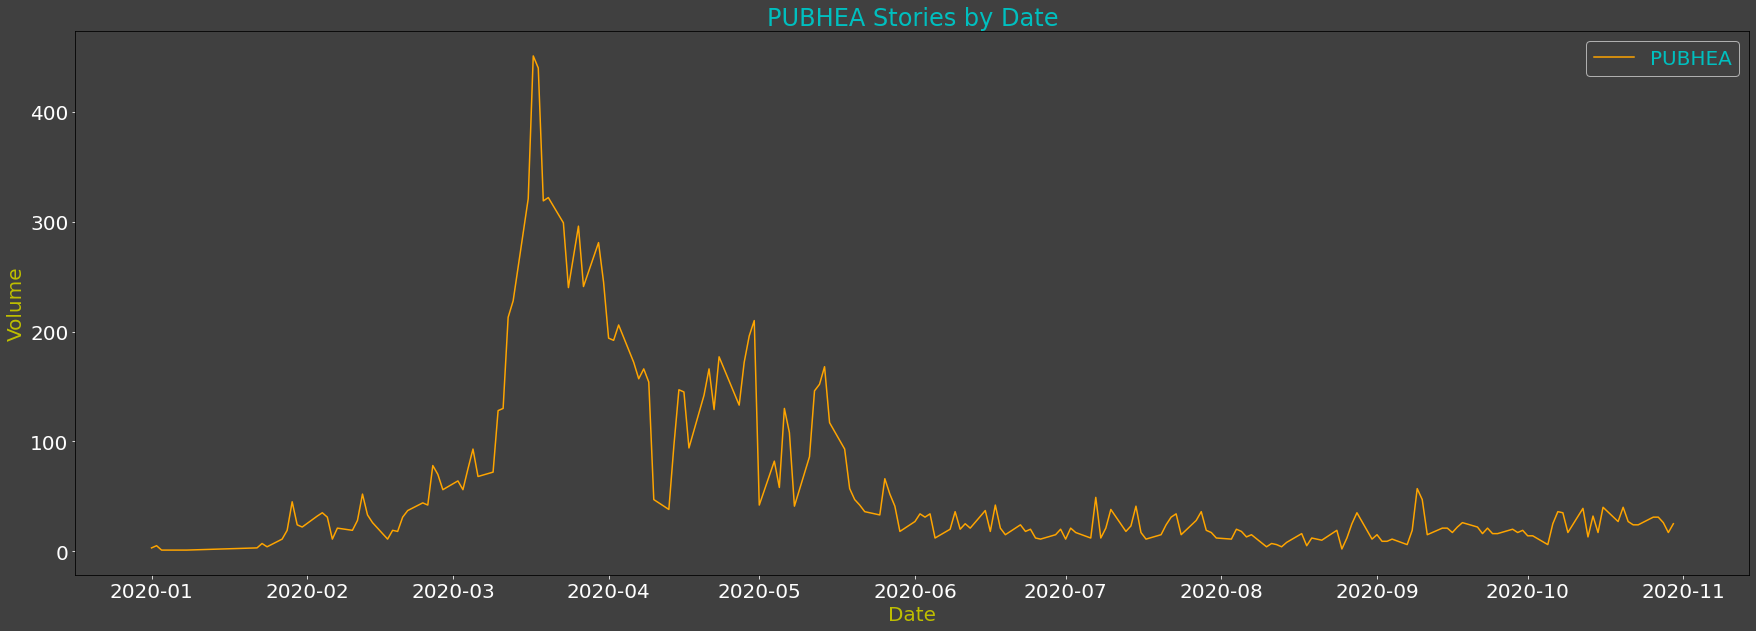

In [10]:
df_pubhea =  plot_topic('PUBHEA')

Public Health systems more likely responded in line with Covid case numbers etc and therefore the pattern is closer to the Disease stories than the Health Policy stories.

<br>

Health/Medicine - **HEA** - Health; disease; medical research; preventative medicine; hospitals; government policy

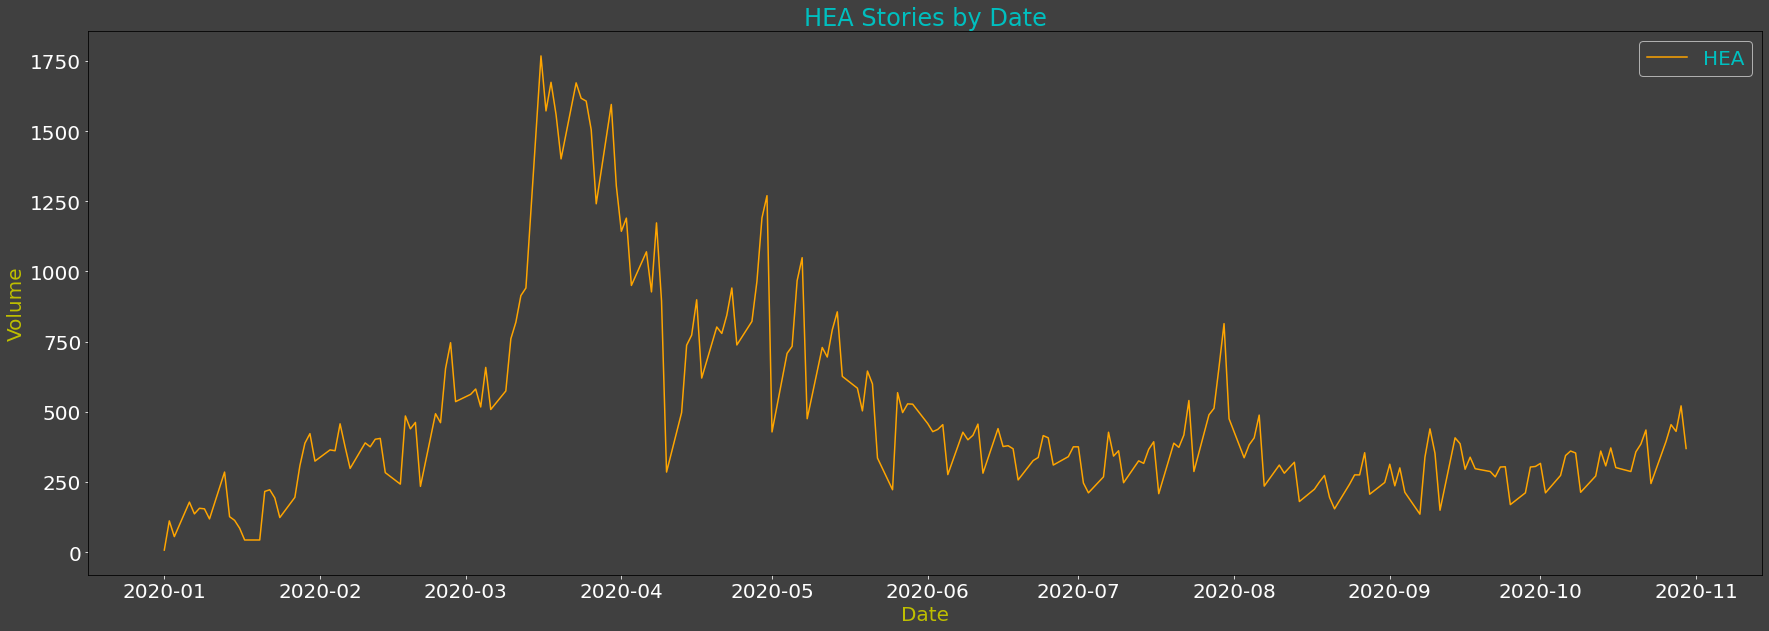

In [11]:

df_hea = plot_topic('HEA')

The **HEA** code is a catch-all code which appears to capture all Health related stories across the different topics - hence the much higher volume of stories.

<br>

#### Compare Volume of stories for related Topic codes

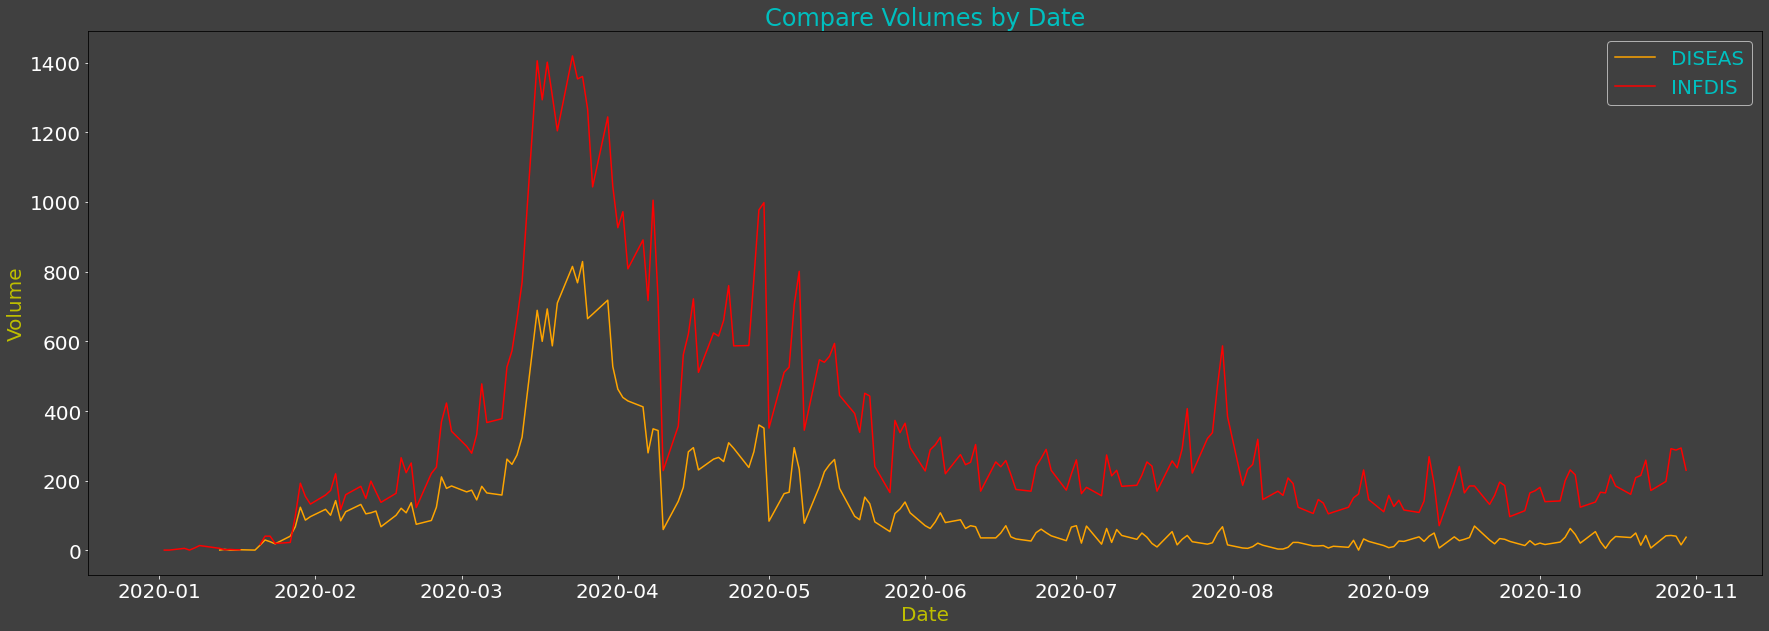

In [12]:
df_merge = plot_compare(df_diseas, df_infdis)

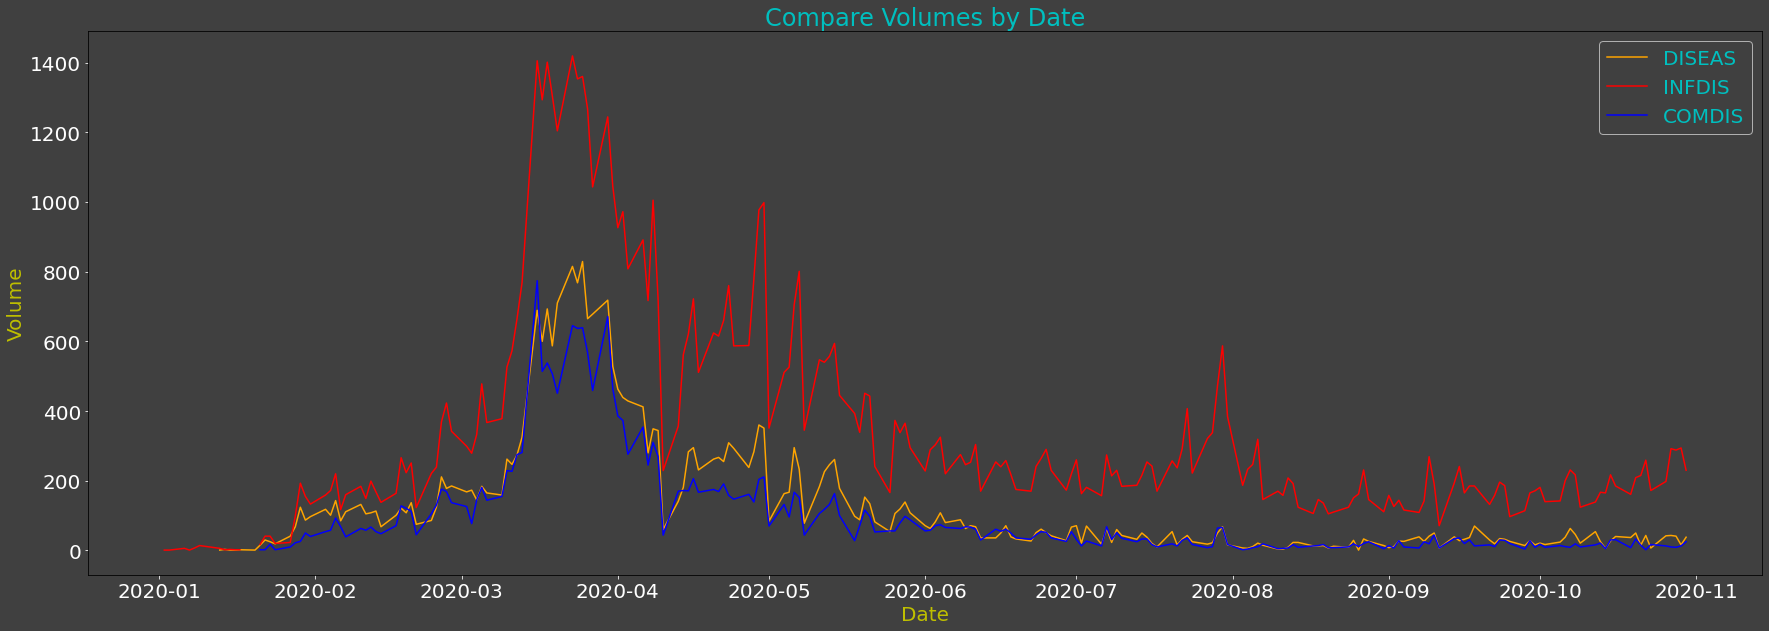

In [13]:
df_merge = plot_compare(df_merge, df_comdis)

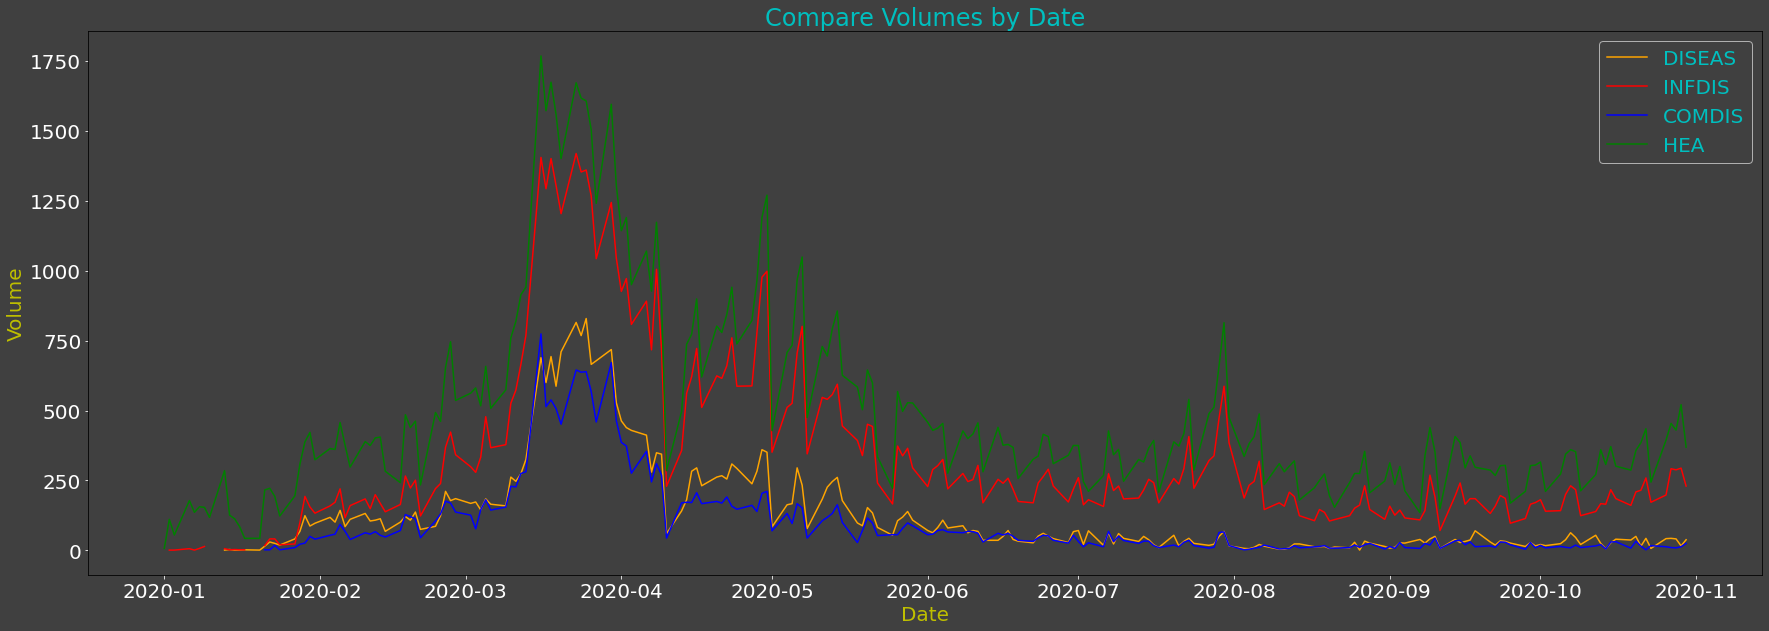

In [14]:
df_merge = plot_compare(df_merge, df_hea)

A few comparison charts - just to reinforce / highlight the similarities and differences between the various Health related topic codes.

<br>



In [15]:
if writeToXl:
    writer.save()
if not loadFromXl:
    myConn.close()

#### Summary

As you can see, we can use the Topic Codes to get an measure the volume of News Stories being published for a given industry or topic.  
Any insight derived from analysing this data can be taken further by applying News Sentiment and Relevance scores to further refine the results of any such analysis.

I touch upon Sentiments scores in my other Notebook - **Crude Oil**
